## Imports de todas as bibliotecas utilizadas


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import seaborn as sns

## Leitura do DataFrame


In [ ]:
drive.mount('/content/drive/')
%cd /content/drive/Shareddrives/ProjetoAM/music-inRecomendation/
df = pd.read_csv('data/dados_treino.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/Shareddrives/ProjetoAM/music-inRecomendation


## Limpeza de dados
Remoção de dados inconsistentes

In [ ]:
df.query('duracao >0', inplace=True)
df.query('PctCantada <= 100 & PctCantada>=0',inplace=True)
df.query('PctRap <= 100 & PctRap>=0',inplace=True)

## Ajustes das variáveis
Substituindo os booleanos para 0 e 1

In [ ]:
df["Tem_Instr_Violao_Viola"] = df["Tem_Instr_Violao_Viola"].astype(int)
df["Tem_Instr_Guitarra"] = df["Tem_Instr_Guitarra"].astype(int)
df["Tem_Instr_Cavaco"] = df["Tem_Instr_Cavaco"].astype(int)
df["Tem_Instr_Sintetizador_Teclado"] = df["Tem_Instr_Sintetizador_Teclado"].astype(int)
df["Tem_Instr_Piano"] = df["Tem_Instr_Piano"].astype(int)
df["Tem_Instr_Metais"] = df["Tem_Instr_Metais"].astype(int)
df["Tem_Instr_Madeiras"] = df["Tem_Instr_Madeiras"].astype(int)
df["Tem_Instr_Cordas"] = df["Tem_Instr_Cordas"].astype(int)
df["aovivo"] = df["aovivo"].astype(int)
df["explicita"] = df["explicita"].astype(int)
df["gostou"] = df["gostou"].astype(int)

Criando o campo da tonalidade maior a partir do `modo` dado:

In [ ]:
def maior(df):
    if df.maior == True:
         return "Maior"
    elif df.maior == False:
         return "Menor"
    else:
        return "NA"


df['maior'] = df['modo'].replace('#',"", regex=False)
df['maior'] = df['maior'].str.isupper()
df['maior'] = df.apply(maior, axis=1)

df['modo']=df['modo'].str.upper()

Separando o *Data Frame* por usuário na base


In [ ]:
users = df["id_cliente"]
print(users.unique())
df_user1 = df.query('id_cliente == "#ID7758"')
df_user2 = df.query('id_cliente == "#ID4820"')

['#ID7758' '#ID4820']


Separando valores em $X$ e $y$

In [ ]:
y_user1 = df_user1['gostou']
y_user2 = df_user2['gostou']

df_x_user1 = df_user1.drop(columns=["gostou", "id_cliente"])
df_x_user2 = df_user2.drop(columns=["gostou", "id_cliente"])

x_user1 = df_x_user1
x_user2 = df_x_user2

**Aplicando** `get_dummies`
 
Esta função transforma os valores das variáveis em colunas com valores binários: 

*   Bateria: eletrônica, acústica e nenhuma  
*   Maior: maior e menor

As dimensões podem ser reduzidas para os dois casos, em que precisamos apenas de 2 colunas para expressar os valores de bateria, e apenas uma coluna para maior.



In [ ]:
x_user1 = pd.get_dummies(data=x_user1, columns=["bateria", "maior"])
x_user1 = x_user1.drop(columns=["bateria_Nenhuma", "maior_NA",'maior_Menor']).rename({'maior_Maior':'maior'})

x_user2 = pd.get_dummies(data=x_user2, columns=["bateria", "maior"])
x_user2 = x_user2.drop(columns=["bateria_Nenhuma", "maior_NA",'maior_Menor']).rename({'maior_Maior':'maior'})


**Aplicando** `labelencoder`

Esta função transforma as variáveis `str` em `int`

In [ ]:
labelencoder = LabelEncoder()
x_user1['modo'] = labelencoder.fit_transform(x_user1['modo'])
x_user2['modo'] = labelencoder.fit_transform(x_user2['modo'])

## Configuração do experimento
Separando valores em $X_{treino}$ , $X_{teste}$ , $y_{treino}$ e $y_{teste}$ para cada um dos usuários

In [ ]:
SEED = 5
np.random.seed(SEED)
#user1
x_train_user1, x_test_user1, y_train_user1, y_test_user1 = train_test_split(x_user1, y_user1, test_size = 0.2,shuffle=True, stratify=y_user1, random_state=42)
#user2
x_train_user2, x_test_user2, y_train_user2, y_test_user2 = train_test_split(x_user2, y_user2, test_size = 0.2,shuffle=True, stratify=y_user2, random_state=42)

### Normalização dos dados
Variáveis normalizadas para $X_{treino}$, $X_{teste}$

*   `BPM`
*   `VolMedio`
*   `PctCantada`
*   `PctRap`
*   `duracao`
*   `n_reproducao`
*   `ano_lancamento`

A normalização deve ser realizada de maneira separada para evitar o *leaking* dos dados de teste nos dados de treino.

In [ ]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['BPM', 'VolMedio','PctCantada','PctRap','duracao','n_reproducao','ano_lancamento']
#x_train_user1
scaler = StandardScaler()
scaler.fit(x_train_user1[cols_to_scale])
x_train_user1[cols_to_scale] = scaler.transform(x_train_user1[cols_to_scale])
#x_train_user2
scaler = StandardScaler()
scaler.fit(x_train_user2[cols_to_scale])
x_train_user2[cols_to_scale] = scaler.transform(x_train_user2[cols_to_scale])
#x_test_user1
scaler = StandardScaler()
scaler.fit(x_test_user1[cols_to_scale])
x_test_user1[cols_to_scale] = scaler.transform(x_test_user1[cols_to_scale])
#x_test_user2
scaler = StandardScaler()
scaler.fit(x_test_user2[cols_to_scale])
x_test_user2[cols_to_scale] = scaler.transform(x_test_user2[cols_to_scale])


### Algoritimos de classificação

Nessa sessão definimos os métodos para o ajuste dos modelos de classificação escolhidos.

O primeiro se trata do modelo **Dummy**, que será utilizado como parametro de comparação de acurácia.

In [ ]:
# Função Dummy
def dummy(x_train, x_test, y_train, y_test):
	dummy_stratified = DummyClassifier(strategy="stratified")
	dummy_stratified.fit(x_train, y_train)
 
	acuracia = dummy_stratified.score(x_test, y_test) * 100
	print("A acurácia do algoritmo [DUMMY] foi %.2f%%" % acuracia)
	return acuracia

Em seguida, temos o modelo de **Regressão logistíca**



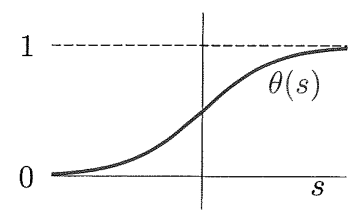

In [ ]:
# Função Regressão logistíca
def logistic_regression(x_train, x_test, y_train, y_test):
  modelo = LogisticRegression(random_state=42)
  modelo.fit(x_train, y_train)
  modelo.score(x_test, y_test)
  
  previsoes = modelo.predict(x_test)
  acuracia = accuracy_score(y_test, previsoes) * 100
  print("A acurácia do algoritmo [LOGISTIC REGRESSION] foi %.2f%%" % acuracia)
  return (modelo, previsoes, acuracia)

Por fim, definimos o modelo de **Random Forest**





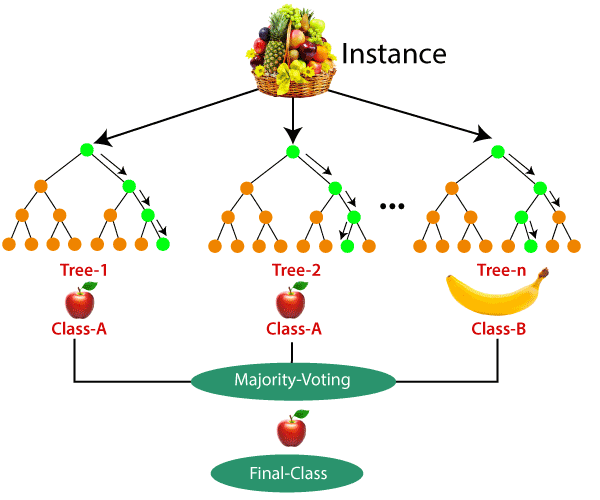

In [ ]:
# Função Random Forest
def randomforest(x_train, x_test, y_train, y_test, n_estimators=1000):
	modelo = RandomForestClassifier(n_estimators=n_estimators)
	modelo.fit(x_train, y_train)
	modelo.score(x_test, y_test)
	previsoes = modelo.predict(x_test)
	acuracia = accuracy_score(y_test, previsoes) * 100
	print("A acurácia do algoritmo [RANDOM FOREST] foi %.2f%%" % acuracia)

	return (modelo, previsoes, acuracia)

## Avaliação de performance dos modelos 

### Acurácia dos modelos testados

In [ ]:
print("USER 1\n")
dummy_user2 = dummy(x_train=x_train_user1, x_test=x_test_user1, y_train=y_train_user1, y_test=y_test_user1)
modelo_lr1, previsao_lr1, acuracia_lr1 = logistic_regression(x_train=x_train_user1, x_test=x_test_user1, y_train=y_train_user1, y_test=y_test_user1)
modelo_rf1, previsao_rf1, acuracia_rf1 = randomforest(x_train=x_train_user1, x_test=x_test_user1, y_train=y_train_user1, y_test=y_test_user1)
print("------------------------\n")

print("USER 2\n")
dummy_user2 = dummy(x_train=x_train_user2, x_test=x_test_user2, y_train=y_train_user2, y_test=y_test_user2)
modelo_lr2, previsao_lr2, acuracia_lr2 = logistic_regression(x_train=x_train_user2, x_test=x_test_user2, y_train=y_train_user2, y_test=y_test_user2)
modelo_rf2, previsao_rf2, acuracia_rf2 = randomforest(x_train=x_train_user2, x_test=x_test_user2, y_train=y_train_user2, y_test=y_test_user2)
print("------------------------\n")

USER 1

A acurácia do algoritmo [DUMMY] foi 51.11%
A acurácia do algoritmo [LOGISTIC REGRESSION] foi 71.72%
A acurácia do algoritmo [RANDOM FOREST] foi 70.51%
------------------------

USER 2

A acurácia do algoritmo [DUMMY] foi 64.69%
A acurácia do algoritmo [LOGISTIC REGRESSION] foi 80.41%
A acurácia do algoritmo [RANDOM FOREST] foi 78.37%
------------------------



Podemos observar que ambos modelos (Random Forest e Logistic Regression) foram superiores ao classificador Dummy.

Ambos tiveram acurácia proxima, porém a regressão logistica apresentou acurácia um pouco maior para ambos usuários.

### Permutation feature importance

Os plots a seguir demonstram as importâncias de cada uma das features para cada um dos modelos para os usuários

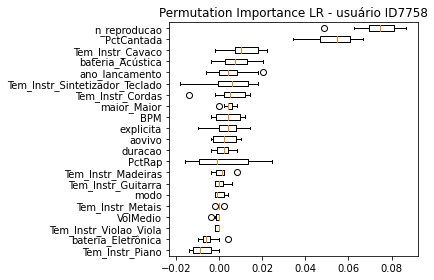

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


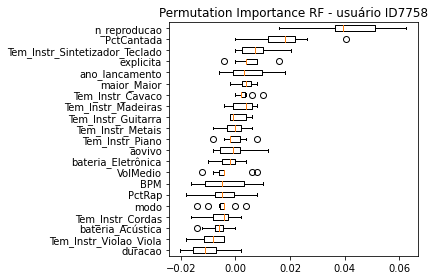

In [ ]:
import warnings
warnings.filterwarnings("ignore")

result = permutation_importance(
    modelo_lr1, x_test_user1, y_test_user1, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_user1.columns[sorted_idx])
ax.set_title("Permutation Importance LR - usuário ID7758")
fig.tight_layout()
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/permplotLR_user1_sb.pdf', dpi=150)

plt.show()



result = permutation_importance(
    modelo_rf1, x_test_user1, y_test_user1, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_user1.columns[sorted_idx])
ax.set_title("Permutation Importance RF - usuário ID7758")
fig.tight_layout()
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/permplotRF_user1_sb.pdf', dpi=150)

plt.show()

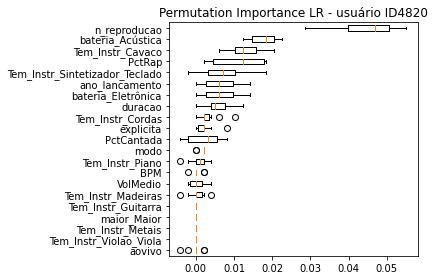

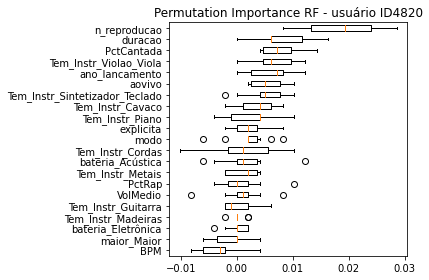

In [ ]:

result = permutation_importance(
    modelo_lr2, x_test_user2, y_test_user2, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_user2.columns[sorted_idx])
ax.set_title("Permutation Importance LR - usuário ID4820")
fig.tight_layout()
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/permplotLR_user2_sb.pdf', dpi=150)

plt.show()


result = permutation_importance(
    modelo_rf2, x_test_user2, y_test_user2, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_user2.columns[sorted_idx])
ax.set_title("Permutation Importance RF - usuário ID4820")
fig.tight_layout()
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/permplotRF_user2_sb.pdf', dpi=150)

plt.show()

### Visualização de métricas de desempenho

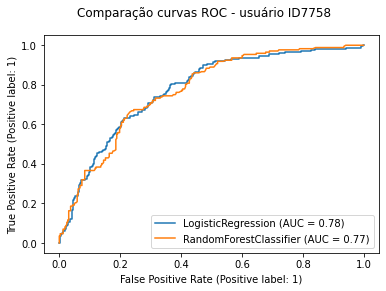

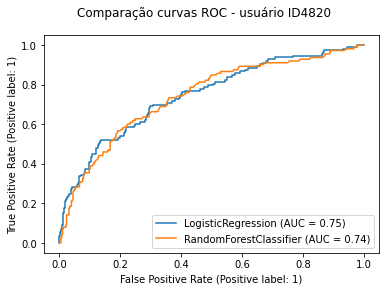

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

#user1
lr_disp=metrics.plot_roc_curve(modelo_lr1, x_test_user1, y_test_user1)
rf_disp=metrics.plot_roc_curve(modelo_rf1, x_test_user1, y_test_user1,ax=lr_disp.ax_)
rf_disp.figure_.suptitle("Comparação curvas ROC - usuário ID7758 ")
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/ROC_user1.pdf', dpi=150)
plt.show()
#user2
lr_disp=metrics.plot_roc_curve(modelo_lr2, x_test_user2, y_test_user2)
rf_disp=metrics.plot_roc_curve(modelo_rf2, x_test_user2, y_test_user2,ax=lr_disp.ax_) 
rf_disp.figure_.suptitle("Comparação curvas ROC - usuário ID4820 ")
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/ROC_user2.pdf', dpi=150)
plt.show()

A partir das curvas ROC notamos  que a regressão logistica possui uma AUC levemente maior do que a random forest.
 

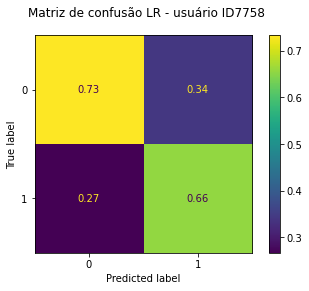

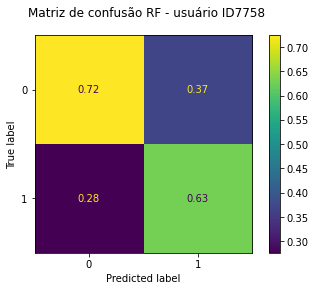

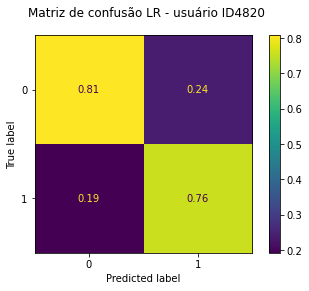

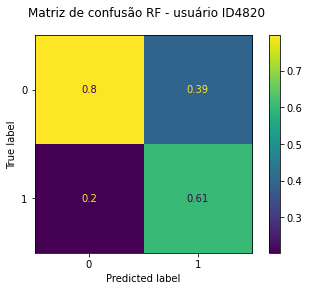

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(modelo_lr1, x_test_user1, y_test_user1, normalize='pred')
plt.suptitle('Matriz de confusão LR - usuário ID7758')
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/CF_LR_user1.pdf', dpi=150)

plt.show()
plot_confusion_matrix(modelo_rf1, x_test_user1, y_test_user1, normalize='pred')
plt.suptitle('Matriz de confusão RF - usuário ID7758')
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/CF_rf_user1.pdf', dpi=150)

plt.show()
plot_confusion_matrix(modelo_lr2, x_test_user2, y_test_user2, normalize='pred')
plt.suptitle('Matriz de confusão LR - usuário ID4820')
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/CF_LR_user2.pdf', dpi=150)

plt.show()
plot_confusion_matrix(modelo_rf2, x_test_user2, y_test_user2, normalize='pred')
plt.suptitle('Matriz de confusão RF - usuário ID4820')
plt.savefig('/content/drive/Shareddrives/ProjetoAM/music-inRecomendation/outputs/CF_rf_user2.pdf', dpi=150)

plt.show()

Por fim, notamos nessas matrizes de confusão (normalizadas pelas colunas) que o modelo de regressão logistica possui uma maior indice de acerto entre para os positívos verdadeiros.